In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
import joblib

scaler_path = Path(r"C:\Users\Developer\TCLab\Data\reward\first.pkl")
reward_scaler = joblib.load(scaler_path)

def compute_reward(t1, t2, tsp1, tsp2, reward_scaler):
    raw_reward = -np.sqrt((t1 - tsp1)**2 + (t2 - tsp2)**2)
    # raw_reward는 1D array임 → reshape 필요
    scaled = reward_scaler.transform(raw_reward.reshape(-1, 1)).flatten()
    return scaled


def compute_errors(t1, t2, tsp1, tsp2):
    e1 = np.abs(t1 - tsp1)
    e2 = np.abs(t2 - tsp2)
    over = np.where(t1 > tsp1, t1 - tsp1, 0) + np.where(t2 > tsp2, t2 - tsp2, 0)
    under = np.where(t1 < tsp1, tsp1 - t1, 0) + np.where(t2 < tsp2, tsp2 - t2, 0)
    return e1.sum(), e2.sum(), over.sum(), under.sum()

def interpolate_df(df, original_dt=5.0, target_dt=5.0):
    n_points = len(df)
    original_t = np.arange(n_points) * original_dt
    new_t = np.arange(0, original_t[-1] + target_dt, target_dt)

    interp_cols = ['T1', 'T2', 'TSP1', 'TSP2', 'Q1', 'Q2']
    interpolated = {}
    for col in interp_cols:
        f = interp1d(original_t, df[col], kind='linear', fill_value='extrapolate')
        interpolated[col] = f(new_t)

    interpolated['time'] = new_t
    return pd.DataFrame(interpolated)

def process_mpc_folder(csv_folder: Path, save_folder: Path):
    csv_files = sorted(csv_folder.glob("mpc_episode_*_data.csv"))
    results = []

    for csv_path in csv_files:
        df = pd.read_csv(csv_path)
        df_interp = interpolate_df(df)

        t1 = df_interp['T1'].values
        t2 = df_interp['T2'].values
        tsp1 = df_interp['TSP1'].values
        tsp2 = df_interp['TSP2'].values

        # 계산
        rewards = compute_reward(t1, t2, tsp1, tsp2, reward_scaler)

        total_return = rewards.sum()

        e1, e2, over, under = compute_errors(t1, t2, tsp1, tsp2)
        total_error = e1 + e2  # 또는 + over + under

        # 그래프 저장
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        t = df_interp['time']
        ax[0].plot(t, t1, label='T1')
        ax[0].plot(t, tsp1, '--', label='TSP1')
        ax[0].plot(t, t2, label='T2')
        ax[0].plot(t, tsp2, '--', label='TSP2')
        ax[0].legend(); ax[0].set_ylabel('Temperature'); ax[0].grid()

        ax[1].plot(t, df_interp['Q1'], label='Q1')
        ax[1].plot(t, df_interp['Q2'], label='Q2')
        ax[1].legend(); ax[1].set_ylabel('Heater (%)'); ax[1].set_xlabel('Time (s)'); ax[1].grid()

        plt.tight_layout()
        fig_name = save_folder / f"{csv_path.stem}_interp.png"
        plt.savefig(fig_name)
        plt.close()

        results.append({
            'file': csv_path.name,
            'return': total_return,
            'E1': e1,
            'E2': e2,
            'Over': over,
            'Under': under,
            'total_error': total_error
        })

    return pd.DataFrame(results)

# 🟢 실행
csv_folder = Path(r"C:\Users\Developer\TCLab\IQL\eval_data_kit\eval_data_kit\csv")   # 수정 가능
save_folder = Path("C:/Users/Developer/TCLab/interp_plot")
save_folder.mkdir(exist_ok=True)

result_df = process_mpc_folder(csv_folder, save_folder)
#print(result_df)

# 🔢 평균값 계산
# 앞의 5개 에피소드에 대한 평균만 계산
mean_first_5 = result_df.iloc[:5][['return', 'E1', 'E2', 'Over', 'Under', 'total_error']].mean()
mean_first_5['file'] = 'Average (first 5)'

# 평균 행 추가
result_df_with_mean = pd.concat([result_df, pd.DataFrame([mean_first_5])], ignore_index=True)

# 출력
print(result_df_with_mean)



                     file     return       E1           E2     Over  \
0  mpc_episode_0_data.csv  65.945157   488.82  1056.480000   364.14   
1  mpc_episode_1_data.csv -17.365499  1003.80  1221.660000  1234.65   
2  mpc_episode_2_data.csv  80.661879   718.29   638.300000   727.38   
3       Average (first 5)  43.080512   736.97   972.146667   775.39   

         Under  total_error  
0  1181.160000  1545.300000  
1   990.810000  2225.460000  
2   629.210000  1356.590000  
3   933.726667  1709.116667  


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.interpolate import interp1d
import joblib

scaler_path = Path(r"C:\Users\Developer\TCLab\Data\reward\first.pkl")
reward_scaler = joblib.load(scaler_path)

def compute_reward(t1, t2, tsp1, tsp2, reward_scaler):
    raw_reward = -np.sqrt((t1 - tsp1)**2 + (t2 - tsp2)**2)
    # raw_reward는 1D array임 → reshape 필요
    scaled = reward_scaler.transform(raw_reward.reshape(-1, 1)).flatten()
    return scaled


def compute_errors(t1, t2, tsp1, tsp2):
    e1 = np.abs(t1 - tsp1)
    e2 = np.abs(t2 - tsp2)
    over = np.where(t1 > tsp1, t1 - tsp1, 0) + np.where(t2 > tsp2, t2 - tsp2, 0)
    under = np.where(t1 < tsp1, tsp1 - t1, 0) + np.where(t2 < tsp2, tsp2 - t2, 0)
    return e1.sum(), e2.sum(), over.sum(), under.sum()

def interpolate_df(df, original_dt=5.0, target_dt=5.0):
    n_points = len(df)
    original_t = np.arange(n_points) * original_dt
    new_t = np.arange(0, original_t[-1] + target_dt, target_dt)

    interp_cols = ['T1', 'T2', 'TSP1', 'TSP2', 'Q1', 'Q2']
    interpolated = {}
    for col in interp_cols:
        f = interp1d(original_t, df[col], kind='linear', fill_value='extrapolate')
        interpolated[col] = f(new_t)

    interpolated['time'] = new_t
    return pd.DataFrame(interpolated)

def process_mpc_folder(csv_folder: Path, save_folder: Path):
    csv_files = sorted(csv_folder.glob("mpc_episode_*_data.csv"))
    results = []

    for csv_path in csv_files:
        df = pd.read_csv(csv_path)
        df_interp = interpolate_df(df)

        t1 = df_interp['T1'].values
        t2 = df_interp['T2'].values
        tsp1 = df_interp['TSP1'].values
        tsp2 = df_interp['TSP2'].values

        # 계산
        rewards = compute_reward(t1, t2, tsp1, tsp2, reward_scaler)

        total_return = rewards.sum()

        e1, e2, over, under = compute_errors(t1, t2, tsp1, tsp2)
        total_error = e1 + e2  # 또는 + over + under

        # 그래프 저장
        fig, ax = plt.subplots(2, 1, figsize=(10, 6))
        t = df_interp['time']
        ax[0].plot(t, t1, label='T1')
        ax[0].plot(t, tsp1, '--', label='TSP1')
        ax[0].plot(t, t2, label='T2')
        ax[0].plot(t, tsp2, '--', label='TSP2')
        ax[0].legend(); ax[0].set_ylabel('Temperature'); ax[0].grid()

        ax[1].plot(t, df_interp['Q1'], label='Q1')
        ax[1].plot(t, df_interp['Q2'], label='Q2')
        ax[1].legend(); ax[1].set_ylabel('Heater (%)'); ax[1].set_xlabel('Time (s)'); ax[1].grid()

        plt.tight_layout()
        fig_name = save_folder / f"{csv_path.stem}_interp.png"
        plt.savefig(fig_name)
        plt.close()

        results.append({
            'file': csv_path.name,
            'return': total_return,
            'E1': e1,
            'E2': e2,
            'Over': over,
            'Under': under,
            'total_error': total_error
        })

    return pd.DataFrame(results)

# 🟢 실행
csv_folder = Path(r"C:\Users\Developer\TCLab\IQL\eval_data_kit\eval_data_simulator\csv")   # 수정 가능
save_folder = Path("C:/Users/Developer/TCLab/interp_plot")
save_folder.mkdir(exist_ok=True)

result_df = process_mpc_folder(csv_folder, save_folder)
#print(result_df)

# 🔢 평균값 계산
# 앞의 5개 에피소드에 대한 평균만 계산
mean_first_5 = result_df.iloc[:5][['return', 'E1', 'E2', 'Over', 'Under', 'total_error']].mean()
mean_first_5['file'] = 'Average (first 5)'

# 평균 행 추가
result_df_with_mean = pd.concat([result_df, pd.DataFrame([mean_first_5])], ignore_index=True)

# 출력
print(result_df_with_mean)



                     file      return          E1           E2        Over  \
0  mpc_episode_0_data.csv   14.404715  291.960000  1548.070000  118.330000   
1  mpc_episode_1_data.csv   43.606640  259.100000  1262.650000  336.420000   
2  mpc_episode_2_data.csv  127.149452  345.890000   543.180000  312.490000   
3       Average (first 5)   61.720269  298.983333  1117.966667  255.746667   

         Under  total_error  
0  1721.700000      1840.03  
1  1185.330000      1521.75  
2   576.580000       889.07  
3  1161.203333      1416.95  


C:\Users\Developer\AppData\Local\Temp\ipykernel_21240\326243432.py:38: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Developer\AppData\Local\Temp\ipykernel_21240\326243432.py:38: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Developer\AppData\Local\Temp\ipykernel_21240\326243432.py:38: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Developer\AppData\Local\Temp\ipykernel_21240\326243432.py:38: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Developer\AppData\Local\Temp\ipykernel_21240\326243432.py:38: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Developer\AppData\Local\Temp\ipykernel_21240\326243432.py:38: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEU

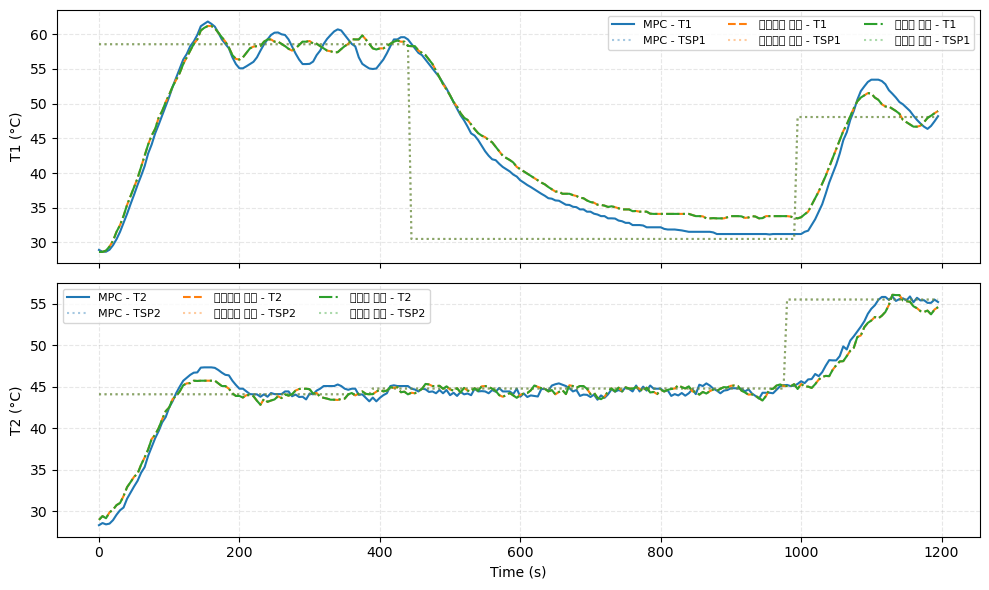

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. 비교할 CSV 목록 --------------------------------------------------------
csv_paths = [
    r"C:\Users\Developer\TCLab\Data\seed6\mpc_episode_1_data.csv",
    r"C:\Users\Developer\TCLab\IQL\offline_infer_online\seed6\rollout.csv",
    r"C:\Users\Developer\TCLab\Data\seed6\rollout.csv",
]

labels = ["MPC", "Offline Training", "Online Tuning"]     # 범례 이름
colors = ["tab:blue", "tab:orange", "tab:green"]
linestyles = ["-", "--", "-."]

# --- 2. 데이터 로드 ------------------------------------------------------------
dfs = [pd.read_csv(p) for p in csv_paths]

# --- 3. 그림 그리기 ------------------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

for df, lbl, c, ls in zip(dfs, labels, colors, linestyles):
    t = df["time"]
    ax[0].plot(t, df["T1"], label=f"{lbl} - T1", color=c, linestyle=ls)
    ax[0].plot(t, df["TSP1"], label=f"{lbl} - TSP1", color=c, linestyle=":", alpha=0.4)
    ax[1].plot(t, df["T2"], label=f"{lbl} - T2", color=c, linestyle=ls)
    ax[1].plot(t, df["TSP2"], label=f"{lbl} - TSP2", color=c, linestyle=":", alpha=0.4)

# --- 4. 축·범례·격자 -----------------------------------------------------------
ax[0].set_ylabel("T1 (°C)")
ax[1].set_ylabel("T2 (°C)")
ax[1].set_xlabel("Time (s)")

for a in ax:
    a.grid(True, linestyle="--", alpha=0.3)
    a.legend(ncol=3, fontsize=8)

plt.tight_layout()
plt.show()


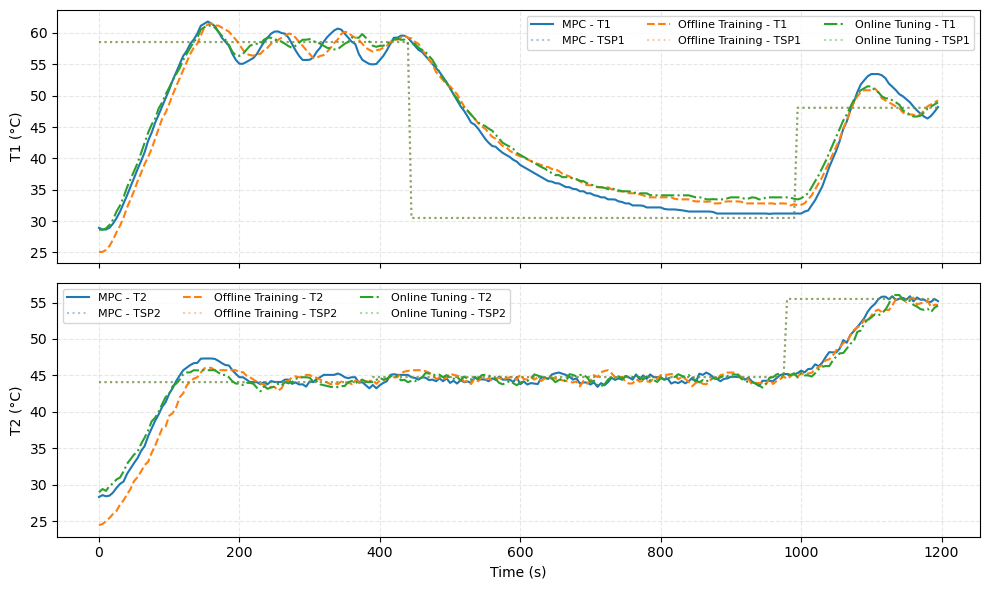

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. 비교할 CSV 목록 + 범례·스타일
# ------------------------------------------------------------------
csv_paths = [
    r"C:\Users\Developer\TCLab\Data\seed6\mpc_episode_1_data.csv",            # MPC
    r"C:\Users\Developer\TCLab\Data\seed6\offline.csv",   # Offline
   # r"C:\Users\Developer\TCLab\Data\seed6\rollout.csv",    
    r"C:\Users\Developer\TCLab\IQL\offline_infer_online\seed6\rollout.csv"                   # Online
]
labels = ["MPC", "Offline Training", "Online Tuning"]
colors = ["tab:blue", "tab:orange", "tab:green"]
linestyles = ["-", "--", "-."]

# ------------------------------------------------------------------
# 2. CSV 로드 + 컬럼 이름 정규화 함수
# ------------------------------------------------------------------
def load_and_normalize(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    # 모든 컬럼명을 소문자로 통일
    df.columns = [c.lower() for c in df.columns]

    # mpc 파일엔 'episode' 열이 있으므로 제거
    if "episode" in df.columns:
        df = df.drop(columns=["episode"])

    # 'time' 컬럼이 반드시 존재하도록 보장
    # (대·소문자 문제 해결됨)
    assert "time" in df.columns, f"'time' column missing in {path}"

    return df

dfs = [load_and_normalize(p) for p in csv_paths]

# ------------------------------------------------------------------
# 3. 그림 그리기
# ------------------------------------------------------------------
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

for df, lbl, c, ls in zip(dfs, labels, colors, linestyles):
    t = df["time"]
    ax[0].plot(t, df["t1"], label=f"{lbl} - T1", color=c, linestyle=ls)
    ax[0].plot(t, df["tsp1"], label=f"{lbl} - TSP1", color=c,
               linestyle=":", alpha=0.4)

    ax[1].plot(t, df["t2"], label=f"{lbl} - T2", color=c, linestyle=ls)
    ax[1].plot(t, df["tsp2"], label=f"{lbl} - TSP2", color=c,
               linestyle=":", alpha=0.4)

# ------------------------------------------------------------------
# 4. 축·범례·격자
# ------------------------------------------------------------------
ax[0].set_ylabel("T1 (°C)")
ax[1].set_ylabel("T2 (°C)")
ax[1].set_xlabel("Time (s)")

for a in ax:
    a.grid(True, linestyle="--", alpha=0.3)
    a.legend(ncol=3, fontsize=8)
### 
plt.tight_layout()
plt.show()
